In [47]:
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print "Import successful"

Import successful


In [48]:
try:
    data = pd.read_csv("train.csv")
    
    print "Quora duplicate questions training dataset has {} samples with {} features each.".format(*data.shape)
    
except:
    print "Dataset(s) could not be loaded. Please check filename is correct and dataset exists"

Quora duplicate questions training dataset has 404290 samples with 6 features each.


In [49]:
print "Display sample of training data:"
display(data.head(10))

Display sample of training data:


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [50]:
print "Display statistics about training data:"
display(data.describe())

Display statistics about training data:


,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614502,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [51]:
#question ids not useful information
data.drop(['id', 'qid1', 'qid2'], axis = 1, inplace = True)

#data.dropna(how = "any", axis = 0, inplace = True)
nan_penalty = 100
print "Modified Quora duplicate questions training dataset has {} samples with {} features each.".format(*data.shape)

#split into features and results
results = data['is_duplicate']
features_raw = data.drop('is_duplicate', axis = 1)

#check training features and results are as expected
display(results.head())
display(features_raw.head())

Modified Quora duplicate questions training dataset has 404290 samples with 3 features each.


0    0
1    0
2    0
3    0
4    0
Name: is_duplicate, dtype: int64

,question1,question2
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?


In [52]:
### Preprocessing function to remove 'stopwords' (common words with little useful information) from the text ###

from sklearn.feature_extraction import stop_words

def remove_stop_words(x):
    try:
        original_words = x.split()
        output = " "

        for word in original_words:
            if not word in stop_words.ENGLISH_STOP_WORDS:
                output += word + " "

        return output[:-1]
    except: #for the case of NaN entries
        return None

In [53]:
#Test that the remove_stop_words function works as expected
print remove_stop_words("Say hello to the cat")
print remove_stop_words("I am six years old")

 Say hello cat
 I years old


In [54]:
features_raw["question1"] = features_raw["question1"].apply(remove_stop_words)
features_raw["question2"] = features_raw["question2"].apply(remove_stop_words)

In [55]:
### Feature engineering - calculate difference in length of both questions, in terms of total number of chars ###

def diff_num_chars(x):
    try:
        len1 = len(x["question1"])
        len2 = len(x["question2"])
        return len1 - len2
    except:
        #print x["question1"]    #print unexpected output for debug
        #print x["question2"]
        return nan_penalty

In [56]:
### Feature engineering - calculate difference in length of both questions, in terms of total number of words ###

def diff_num_words(x):
    try:
        len1 = len(x["question1"].split())
        len2 = len(x["question2"].split())
        return len1 - len2
    except:
        #print x["question1"]   #print unexpected output for debug
        #print x["question2"]
        return nan_penalty

In [57]:
### Feature engineering - count number of common words between both questions ###

def num_common_words(x):
    try:
        words1 = x["question1"].split()
        words2 = x["question2"].split()
        
        common_words = 0
        
        for word in words1:
            if word in words2:
                common_words += 1
                
        return common_words
        
    except:
        #print x["question1"]  #print unexpected output for debug
        #print x["question2"]
        return 0

In [58]:
features = pd.DataFrame()
features["diff_num_chars"] = features_raw.apply(diff_num_chars, axis=1)
features["diff_num_words"] = features_raw.apply(diff_num_words, axis=1)
features["num_common_words"] = features_raw.apply(num_common_words, axis=1)
display(features.head())

,diff_num_chars,diff_num_words,num_common_words
0,6,1,6
1,-30,-4,3
2,10,2,2
3,-12,3,0
4,35,5,1


In [59]:
from sklearn.cross_validation import train_test_split

#Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, results, test_size = 0.2, random_state = 17)

print "Training and testing split was successful."

Training and testing split was successful.


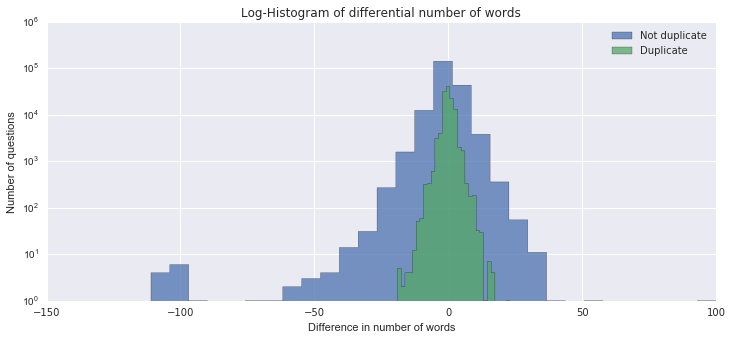

In [65]:
### Visualisation - plot histogram showing how distrubtion of differential number of words between both questions
### varies between duplicate and non-duplicate questions ###

# Histogram plotting techniques inspired by:
# https://www.kaggle.com/anokas/quora-question-pairs/data-analysis-xgboost-starter-0-35460-lb

plt.figure(figsize=(12, 5))
plt.hist(X_train["diff_num_words"][y_train == 0], bins=30, histtype="stepfilled", alpha = 0.75,label="Not duplicate")
plt.hist(X_train["diff_num_words"][y_train == 1], bins=30, histtype="stepfilled", alpha = 0.75, label="Duplicate")
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of differential number of words')
plt.xlabel('Difference in number of words')
plt.ylabel('Number of questions')
plt.legend()
print

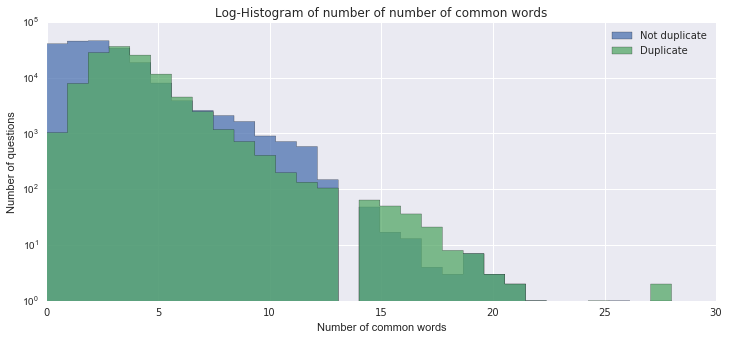

In [63]:
### Visualisation - plot histogram showing how distrubtion of number of common words between both questions
### varies between duplicate and non-duplicate questions ###

plt.figure(figsize=(12, 5))
plt.hist(X_train["num_common_words"][y_train == 0], bins=30, histtype="stepfilled", alpha = 0.75, label="Not duplicate")
plt.hist(X_train["num_common_words"][y_train == 1], bins=30, histtype="stepfilled", alpha = 0.75, label="Duplicate")
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of number of number of common words')
plt.xlabel('Number of common words')
plt.ylabel('Number of questions')
plt.legend()
print

In [14]:
from sklearn.metrics import log_loss

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'  
    score = log_loss(y_true, y_predict)
    
    # Return the score
    return score

In [ ]:
from sklearn.metrics import make_scorer
#from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)

    # Create regressor object
    #regressor = DecisionTreeRegressor()
    regressor = RandomForestRegressor(n_estimators = 20)

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':(1, 2, 5, 10, None)}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search object
    grid = GridSearchCV(estimator = regressor, param_grid = params, scoring = scoring_fnc, cv = cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [ ]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print "Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth'])

In [ ]:
#test_questions = [["Hello", "Hello world"], ["Why is the sky blue?", "Why is the sky not blue?"], ["What is pi?", "What is pi?"]]
print features_raw["question1"][3411], features_raw["question2"][3411]
display(X_test.head(20))
reg.predict(X_test.head(20))

print performance_metric(y_test, reg.predict(X_test))

In [ ]:
#Load the competition testing data set

try:
    test_data = pd.read_csv("test.csv")
    
    print "Quora duplicate questions competion test dataset has {} samples with {} features each.".format(*test_data.shape)
    
except:
    print "Dataset(s) could not be loaded. Please check filename is correct and dataset exists"

In [ ]:
display(test_data.head())

test_data["question1"] = test_data["question1"].apply(remove_stop_words)
test_data["question2"] = test_data["question2"].apply(remove_stop_words)

test_data_features = pd.DataFrame()
#test_data_features["diff_num_chars"] = test_data.apply(diff_num_chars, axis=1)
test_data_features["diff_num_words"] = test_data.apply(diff_num_words, axis=1)
test_data_features["num_common_words"] = test_data.apply(num_common_words, axis=1)
display(test_data_features.head())

In [ ]:
test_predictions = reg.predict(test_data_features)
#print "Test_data_features shape: ", test_data_features.shape
#print "Test_predictions shape: ", test_predictions.shape
final_output = pd.concat([test_data["test_id"], pd.Series(test_predictions, name = "is_duplicate")], axis=1)

#print "Final output has {} samples with {} features each.".format(*final_output.shape)
#print final_output["test_id"][2345793],final_output["is_duplicate"][2345793]

display(final_output.head())

In [ ]:
final_output.to_csv("final_output.csv", index = False)
print "Final predictions written to final_output.csv successfully"